# Basic Time Series with Neural Networks

A time series is an array of data which consists of a an array of points, each of which contains one or more features. The crucial characteristic of time series is that we use them to model temporal dependencies, meaning that we want to perform operations based on the series.
Example tasks for time series would be 
- predicting future stock prices based on current stock prices (univariate time series prediction)
- predicting future weather based on current temperature, humidity and other weather (multivariate time series prediction)
- Classifying the emotion of a piece of music (classifying a whole time series)
- Classifying changes in emotion over multiple scenes (classifying each step of a time series).

For all of these tasks Recurrent Neural Networks (RNN) can be very useful, since the RNN tries to capture the temporal component of the data by feeding each timestep into the network one by one. Especially LSTMs, which include both a "short-term" and a "long-term" memory state or even the simpler GRUs (Gatet Recurrent Units) are widley used. 

In this notebook, you will be working on a modified version of the Air Pollution Dataset, which contains weather data and air pollution measurements done in Peking, China. Your task will be forecasting the pollution of the next measurement.

In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, GRU, Dense,Flatten,Dropout,Conv1D, GlobalAveragePooling1D
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.model_selection import train_test_split
import seaborn as sns
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
sns.set_style("darkgrid")

Using TensorFlow backend.


In [2]:
def plot_model_history(history, ax=None, metric='loss', ep_start=1, ep_stop=None, monitor='val_loss', mode='min', plttitle=None):
    if ax is None:
        fig,ax = plt.subplots()
    if ep_stop is None:
        ep_stop = len(history.epoch)
    if plttitle is None:
        plttitle = metric[0].swapcase() + metric[1:] + ' During Training'
    ax.plot(np.arange(ep_start,ep_stop+1, dtype='int'),history.history[metric][ep_start-1:ep_stop])
    ax.plot(np.arange(ep_start,ep_stop+1, dtype='int'),history.history['val_' + metric][ep_start-1:ep_stop])
    ax.set(title=plttitle)
    ax.set(ylabel=metric[0].swapcase() + metric[1:])
    ax.set(xlabel='Epoch')
    ax.legend(['train', 'val'], loc='upper right')

In [3]:
# custom R2-score metrics for keras backend
from keras import backend as K

def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [4]:
data = pd.read_csv('pollution.csv', header=0, index_col=0)
data = data.dropna()
values = data.values
print('datapoints:', len(data))
data

datapoints: 43800


dew  temp   press  wnd_spd  snow  rain  pollution
date                                                                  
2010-01-02 00:00:00  -16  -4.0  1020.0     1.79     0     0        129
2010-01-02 01:00:00  -15  -4.0  1020.0     2.68     0     0        148
2010-01-02 02:00:00  -11  -5.0  1021.0     3.57     0     0        159
2010-01-02 03:00:00   -7  -5.0  1022.0     5.36     1     0        181
2010-01-02 04:00:00   -7  -5.0  1022.0     6.25     2     0        138
...                  ...   ...     ...      ...   ...   ...        ...
2014-12-31 19:00:00  -23  -2.0  1034.0   231.97     0     0          8
2014-12-31 20:00:00  -22  -3.0  1034.0   237.78     0     0         10
2014-12-31 21:00:00  -22  -3.0  1034.0   242.70     0     0         10
2014-12-31 22:00:00  -22  -4.0  1034.0   246.72     0     0          8
2014-12-31 23:00:00  -21  -3.0  1034.0   249.85     0     0         12

[43800 rows x 7 columns]

Let us first plot the data.

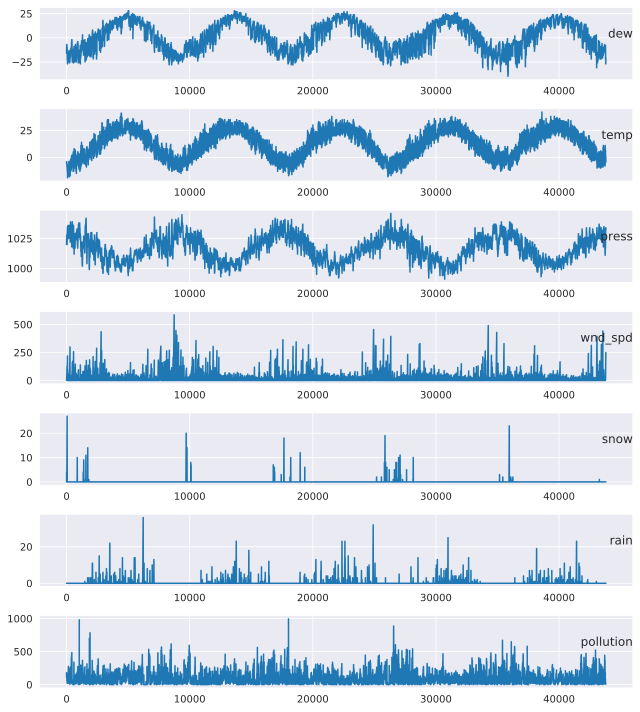

In [5]:
groups = [0, 1, 2, 3, 4, 5, 6]
i = 1
# plot each column
plt.figure(figsize=(9,10))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(data.columns[group], y=0.5, loc='right')
    i += 1
plt.tight_layout()

For time series prediction, there is always the issue of how training and test data are to be split. For our purposes, we will use a so called walk forward validation, i.e. taking the **last 12 hours** of weather and polution data to predict the next entry of polution data. In this way one "sample" consists of a time series of length 12 (with 7 variables at each time step) and one target. 

**Task**: Reformat the data so that we have a 3D array of *non-overlapping* samples and a vector of targets.

_Remark_: The use of a window of 12 hours as well as all the network architectures are chosen more or less arbitrary. In a single notebook to be shown in a lecture on a machine with consumer compute capabillity there is no other way. But for a serious project you should always valiadate and tune your parameters. The window size would be one of this parameters!

In [6]:
X = np.zeros((len(data.index)//13,12,7)) # pre-allocate X and y
y = np.zeros((len(data.index)//13,1))    
count = 0
for i in range(0,len(data.index)-13,13):
    X[count,:,:]= data.iloc[i:i+12,:]
    y[count]=data.iloc[i+12,6]
    count = count+1

#print('Sample 0 Features', X[0,:,6])
#print('Sample 0 Label', y[0])
#data.head(14)

<img src="https://i.ibb.co/w7K9L59/untitled-1.png" width=700>

Now, for X we have a tensor with _samples_ _x_ _timesteps_ _x_ _features_. We can now split our data into train and test set. Take care, that in our case we are only interested in the "time windows" we generated. Whereas the timesteps in each "sample" are consecutive, the time-steps between 2 "samples" are not consinstent. Furthermore, each timestep of the measurement it used only once, such that the "samples" are independent (in their timesteps).

_Remark_: Even if the slices are not overlapping in time, we still have to expect a correlation between consecutive slies. Think for example of a long term trend, e.g. a linear growth of the pollution over the years. First we break up such trends by shuffeling and secondly we might get an over-optimistic estimate of the performance of our model. A strategy (as shown in the end of the notebook) would be to use 2010, 2012, 2013 for training, 2013 for validation and 2014 for testing.
Please have a look into the lecture slides for (cross-)validation techniques for time series.

In [7]:
X_train,X_test,y_train,y_test = train_test_split(X,y,shuffle=True,random_state=42,test_size=0.3)
n_steps = X_train.shape[1]
n_feats = X_train.shape[2]

__Task__: Fill the functions below with your network architectures. Use a recurrent network with _GRU_ layer(s), a MLP with only dense layers and a CNN. 

In [8]:
def build_model_gru(n_steps,n_feats,n_fore=1):
    model = Sequential()
    model.add(GRU(256, return_sequences=True, input_shape=(n_steps,n_feats),name="gru1"))
    model.add(GRU(128, name="gru2"))
    model.add(Dense(128,activation="relu",name="hidden1"))
    model.add(Dense(64,activation="relu",name="hidden2"))
    model.add(Dense(16,activation="relu",name="hidden3"))
    model.add(Dense(n_fore,activation="linear",name="output"))
    model.compile(loss='mse', optimizer='adam',metrics=[r2_keras])
    return model

def build_model_mlp(n_steps,n_feats,n_fore=1):
    model = Sequential()
    model.add(Flatten(input_shape=(n_steps,n_feats)))
    model.add(Dense(64,activation="relu",name="hidden1"))
    model.add(Dense(32,activation="relu",name="hidden2"))
    model.add(Dense(16,activation="relu",name="hidden3"))
    model.add(Dense(n_fore,activation="linear",name="output"))
    model.compile(loss='mse', optimizer='adam',metrics=[r2_keras])
    return model

def build_model_cnn(n_steps,n_feats,n_fore=1):
    model = Sequential()
    model.add(Conv1D(filters=128, kernel_size=7, activation='relu',input_shape=(n_steps,n_feats)))
    model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
    model.add(Flatten())
    model.add(Dropout(0.20))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(n_fore, activation='linear'))
    model.compile(optimizer='adam', loss='mse', metrics=[r2_keras])
    return model

Lets train the models.

In [9]:
cnn = build_model_cnn(n_steps,n_feats)
gru = build_model_gru(n_steps,n_feats)
mlp = build_model_mlp(n_steps,n_feats)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
history_cnn = cnn.fit(X_train, y_train, validation_split=0.25, epochs=100, callbacks=[es], verbose=0)
history_mlp = mlp.fit(X_train, y_train, validation_split=0.25, epochs=100, callbacks=[es], verbose=0)
history_gru = gru.fit(X_train, y_train, validation_split=0.25, epochs=100, callbacks=[es], verbose=0)

Restoring model weights from the end of the best epoch
Epoch 00065: early stopping
Restoring model weights from the end of the best epoch
Epoch 00045: early stopping
Restoring model weights from the end of the best epoch
Epoch 00027: early stopping


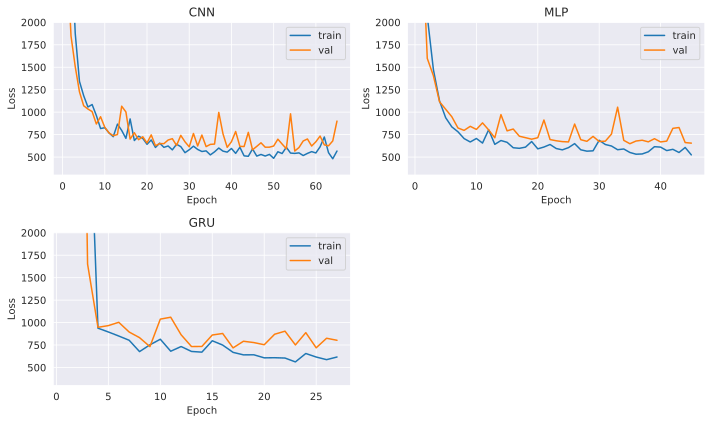

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(10,6))
plot_model_history(history_cnn, ax = ax[0,0], plttitle='CNN')
plot_model_history(history_mlp, ax = ax[0,1], plttitle='MLP')
plot_model_history(history_gru, ax = ax[1,0], plttitle='GRU')
ax[0,0].set_ylim([300,2000])
ax[0,1].set_ylim([300,2000])
ax[1,0].set_ylim([300,2000])
ax.flat[-1].set_visible(False)
plt.tight_layout()

Ok, how are we doing on train and test set?

In [15]:
models = [cnn,mlp,gru]
modelnames = ['CNN', 'MLP', 'GRU']
for i,nme in enumerate(modelnames):
    print(nme)
    print(models[i].evaluate(X_train,y_train))
    print(models[i].evaluate(X_test,y_test))
    print('------')

CNN
2358/2358 [==============================] - 0s 167us/step
[436.39890667864387, 0.9353695511817932]
1011/1011 [==============================] - 0s 44us/step
[656.5113387140865, 0.9073579907417297]
------
MLP
2358/2358 [==============================] - 0s 16us/step
[535.8053810954398, 0.920767605304718]
1011/1011 [==============================] - 0s 21us/step
[710.8433634440104, 0.9017382860183716]
------
GRU
2358/2358 [==============================] - 2s 649us/step
[626.0942741568762, 0.9123135209083557]
1011/1011 [==============================] - 1s 651us/step
[817.7964099616137, 0.8883476853370667]
------


Looks pretty! But what is it good for? Implement a dummy forecaster!

In [16]:
def dummy_prediction(X):
    y_pred = X[:,-1,-1]
    return y_pred

Lets check the results...

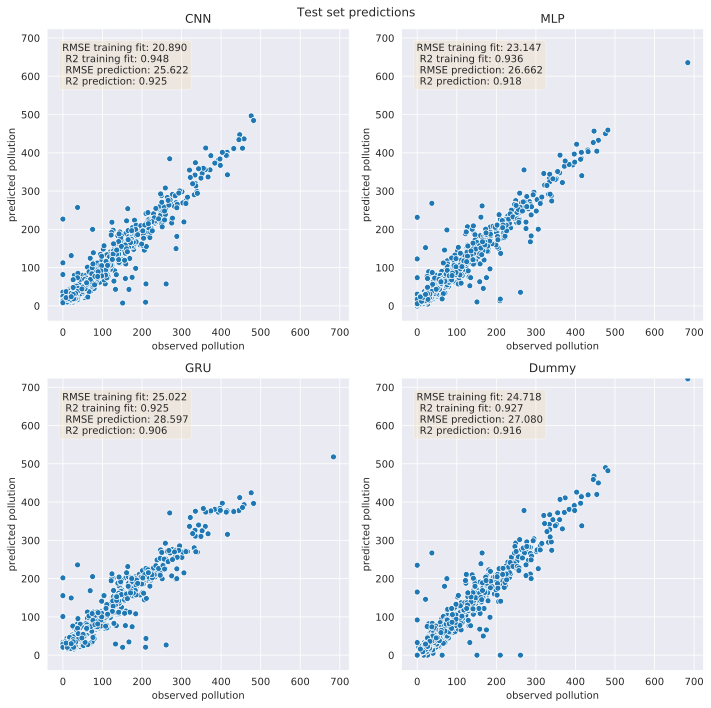

In [17]:
y_pred_train = np.zeros((y_train.shape[0],4))
y_pred_test = np.zeros((y_test.shape[0],4))
modelnames = ['CNN', 'MLP', 'GRU', 'Dummy']
for i,nme in enumerate(modelnames):
    if i==3:
        y_pred_train[:,i] = dummy_prediction(X_train).ravel()
        y_pred_test[:,i] = dummy_prediction(X_test).ravel()
    else:
        y_pred_train[:,i] = models[i].predict(X_train).ravel()
        y_pred_test[:,i] = models[i].predict(X_test).ravel()
        
fig, axs = plt.subplots(2, 2, figsize=(10,10))
for i,ax in enumerate(axs.flat):
    textstr = 'RMSE training fit: %.03f\n R2 training fit: %.03f\n RMSE prediction: %.03f\n R2 prediction: %.03f' % (np.sqrt(mean_squared_error(y_train,y_pred_train[:,i])),
                                                                                                                    r2_score(y_train,y_pred_train[:,i]),
                                                                                                                    np.sqrt(mean_squared_error(y_test,y_pred_test[:,i])),
                                                                                                                    r2_score(y_test,y_pred_test[:,i]))
    minlim = y_test.min()
    maxlim = y_test.max()
    sns.scatterplot(x=y_test.ravel(),y=y_pred_test[:,i],ax=ax)
    ax.set_xlabel('observed pollution')
    ax.set_ylabel('predicted pollution')
    ax.set_xlim(minlim-40, maxlim+40)
    ax.set_ylim(minlim-40, maxlim+40)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
    ax.set_title(modelnames[i])
fig.suptitle('Test set predictions')
fig.tight_layout()
fig.subplots_adjust(top=0.95)

So far so good. Now let's make the task more challenging. Start from the beginning and re-structure the data again as given on the illustration below. Try to forecast the values for two hours from the last 12 hours.

<img src="https://i.ibb.co/y476tf8/untitled-2.png" width=700>

__Task:__ Fill X and y according to the image. y is now 2D (having 2 timesteps).

In [18]:
X = np.zeros((len(data.index)//13,12,7)) # pre-allocate X and y
y = np.zeros((len(data.index)//13,2))    
count = 0
for i in range(0,len(data.index)-14,14):
    X[count,:,:]= data.iloc[i:i+12,:]
    y[count,:]=data.iloc[i+12:i+14,6]
    count = count+1
print('Sample 0 Features', X[0,:,6])
print('Sample 0 Label', y[0,:])
print('----')
print('Sample 0 Features', X[1,:,6])
print('Sample 0 Label', y[1,:])
data.head(30)

Sample 0 Features [129. 148. 159. 181. 138. 109. 105. 124. 120. 132. 140. 152.]
Sample 0 Label [148. 164.]
----
Sample 0 Features [158. 154. 159. 164. 170. 149. 154. 164. 156. 126.  90.  63.]
Sample 0 Label [65. 55.]


dew  temp   press  wnd_spd  snow  rain  pollution
date                                                                  
2010-01-02 00:00:00  -16  -4.0  1020.0     1.79     0     0        129
2010-01-02 01:00:00  -15  -4.0  1020.0     2.68     0     0        148
2010-01-02 02:00:00  -11  -5.0  1021.0     3.57     0     0        159
2010-01-02 03:00:00   -7  -5.0  1022.0     5.36     1     0        181
2010-01-02 04:00:00   -7  -5.0  1022.0     6.25     2     0        138
2010-01-02 05:00:00   -7  -6.0  1022.0     7.14     3     0        109
2010-01-02 06:00:00   -7  -6.0  1023.0     8.93     4     0        105
2010-01-02 07:00:00   -7  -5.0  1024.0    10.72     0     0        124
2010-01-02 08:00:00   -8  -6.0  1024.0    12.51     0     0        120
2010-01-02 09:00:00   -7  -5.0  1025.0    14.30     0     0        132
2010-01-02 10:00:00   -7  -5.0  1026.0    17.43     1     0        140
2010-01-02 11:00:00   -8  -5.0  1026.0    20.56     0     0        152
2010-01-02 12:00:00   -8  -5.0  1026.0    23.69     0     0        148
2010-01-02 13:00:00   -8  -5.0  1025.0    27.71     0     0        164
2010-01-02 14:00:00   -9  -5.0  1025.0    31.73     0     0        158
2010-01-02 15:00:00   -9  -5.0  1025.0    35.75     0     0        154
2010-01-02 16:00:00   -9  -5.0  1026.0    37.54     0     0        159
2010-01-02 17:00:00   -8  -5.0  1027.0    39.33     0     0        164
2010-01-02 18:00:00   -8  -5.0  1027.0    42.46     0     0        170
2010-01-02 19:00:00   -8  -5.0  1028.0    44.25     0     0        149
2010-01-02 20:00:00   -7  -5.0  1028.0    46.04     0     0        154
2010-01-02 21:00:00   -7  -5.0  1027.0    49.17     1     0        164
2010-01-02 22:00:00   -8  -6.0  1028.0    52.30     2     0        156
2010-01-02 23:00:00   -8  -6.0  1027.0    55.43     3     0        126
2010-01-03 00:00:00   -7  -6.0  1027.0    58.56     4     0         90
2010-01-03 01:00:00   -8  -6.0  1026.0    61.69     5     0         63
2010-01-03 02:00:00   -8  -7.0  1026.0    65.71     6     0         65
2010-01-03 03:00:00   -8  -7.0  1025.0    68.84     7     0         55
2010-01-03 04:00:00   -8  -7.0  1024.0    72.86     8     0         65
2010-01-03 05:00:00   -9  -8.0  1024.0    76.88     9     0         83

In [19]:
X_train,X_test,y_train,y_test = train_test_split(X,y,shuffle=True,random_state=42,test_size=0.2)
n_steps = X_train.shape[1]
n_feats = X_train.shape[2]
n_fore = y_train.shape[1]

Lets re-train our models!

In [20]:
cnn = build_model_cnn(n_steps,n_feats,n_fore)
gru = build_model_gru(n_steps,n_feats,n_fore)
mlp = build_model_mlp(n_steps,n_feats,n_fore)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
history_cnn = cnn.fit(X_train, y_train, validation_split=0.25, epochs=100, callbacks=[es], verbose=0)
history_mlp = mlp.fit(X_train, y_train, validation_split=0.25, epochs=100, callbacks=[es], verbose=0)
history_gru = gru.fit(X_train, y_train, validation_split=0.25, epochs=100, callbacks=[es], verbose=0)

Restoring model weights from the end of the best epoch
Epoch 00028: early stopping
Restoring model weights from the end of the best epoch
Epoch 00062: early stopping
Restoring model weights from the end of the best epoch
Epoch 00020: early stopping


__Task:__ Create a new `dummy_prediction()` function!

In [21]:
def dummy_prediction(X):
    y_pred = np.concatenate([X[:,-1,-1].reshape(-1,1),X[:,-1,-1].reshape(-1,1)],axis=1)
    return y_pred

Lets inspect and plot the results.

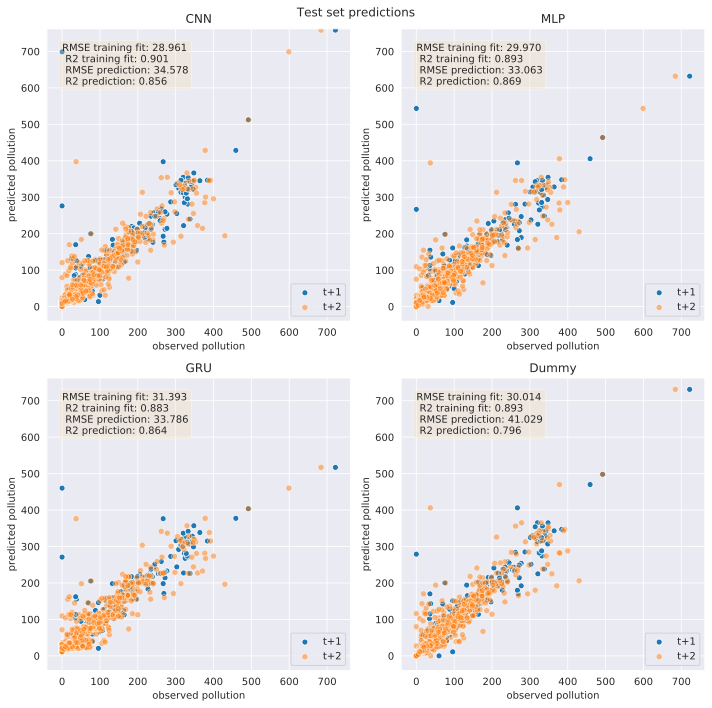

In [22]:
y_pred_train = np.zeros((y_train.shape[0],2,4))
y_pred_test = np.zeros((y_test.shape[0],2,4))
modelnames = ['CNN', 'MLP', 'GRU', 'Dummy']
for i,nme in enumerate(modelnames):
    if i==3:
        y_pred_train[:,:,i] = dummy_prediction(X_train)
        y_pred_test[:,:,i] = dummy_prediction(X_test)
    else:
        y_pred_train[:,:,i] = models[i].predict(X_train)
        y_pred_test[:,:,i] = models[i].predict(X_test)
        
fig, axs = plt.subplots(2, 2, figsize=(10,10))
for i,ax in enumerate(axs.flat):
    textstr = 'RMSE training fit: %.03f\n R2 training fit: %.03f\n RMSE prediction: %.03f\n R2 prediction: %.03f' % (np.sqrt(mean_squared_error(y_train,y_pred_train[:,:,i])),
                                                                                                                    r2_score(y_train,y_pred_train[:,:,i]),
                                                                                                                    np.sqrt(mean_squared_error(y_test,y_pred_test[:,:,i])),
                                                                                                                    r2_score(y_test,y_pred_test[:,:,i]))
    minlim = y_test.min()
    maxlim = y_test.max()
    sns.scatterplot(x=y_test[:,0],y=y_pred_test[:,0,i],ax=ax, label='t+1')
    sns.scatterplot(x=y_test[:,1],y=y_pred_test[:,1,i],ax=ax,alpha=.5, label='t+2')
    ax.set_xlabel('observed pollution')
    ax.set_ylabel('predicted pollution')
    ax.set_xlim(minlim-40, maxlim+40)
    ax.set_ylim(minlim-40, maxlim+40)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
    ax.set_title(modelnames[i])
    ax.legend(loc=4)
fig.suptitle('Test set predictions')
fig.tight_layout()
fig.subplots_adjust(top=0.95)

So far we used a random train/test split. But what if we want to know how our model works to predict the next two hours of the pollution in 2014! Once again restructure your data. Split the data such that no data from the year 2014 are in the training set. Define the test set to contain only data from 2014. Check your results!

__Task:__ Create the respective training and test sets!

In [23]:
train = data[data.index < '2014-01-01-00:00']
test = data[data.index >= '2014-01-01-00:00']
X_train = np.zeros((len(train.index)//13,12,7)) # pre-allocate X and y
y_train = np.zeros((len(train.index)//13,2))   
X_test = np.zeros((len(test.index)//13,12,7)) # pre-allocate X and y
y_test = np.zeros((len(test.index)//13,2))   
count = 0
for i in range(0,len(train.index)-14,14):
    X_train[count,:,:]= train.iloc[i:i+12,:]
    y_train[count,:]=train.iloc[i+12:i+14,6]
    count = count+1
count=0
for i in range(0,len(test.index)-14,14):
    X_test[count,:,:]= test.iloc[i:i+12,:]
    y_test[count,:]=test.iloc[i+12:i+14,6]
    count = count+1

In [24]:
n_steps = X_train.shape[1]
n_feats = X_train.shape[2]
n_fore = y_train.shape[1]

Refit the models.

In [25]:
cnn = build_model_cnn(n_steps,n_feats,n_fore)
gru = build_model_gru(n_steps,n_feats,n_fore)
mlp = build_model_mlp(n_steps,n_feats,n_fore)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
history_cnn = cnn.fit(X_train, y_train, validation_split=0.25, epochs=100, callbacks=[es], verbose=0)
history_mlp = mlp.fit(X_train, y_train, validation_split=0.25, epochs=100, callbacks=[es], verbose=0)
history_gru = gru.fit(X_train, y_train, validation_split=0.25, epochs=100, callbacks=[es], verbose=0)

Restoring model weights from the end of the best epoch
Epoch 00023: early stopping
Restoring model weights from the end of the best epoch
Epoch 00049: early stopping
Restoring model weights from the end of the best epoch
Epoch 00017: early stopping


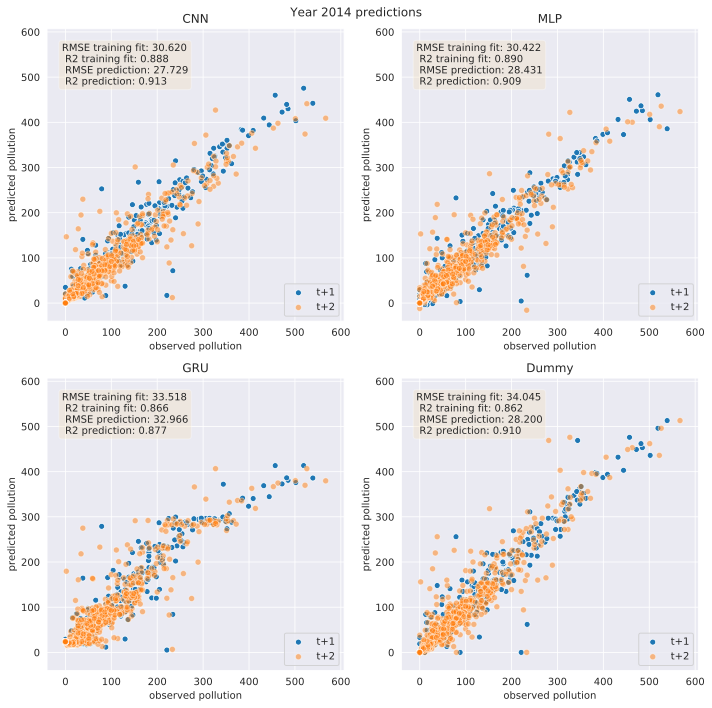

In [26]:
y_pred_train = np.zeros((y_train.shape[0],2,4))
y_pred_test = np.zeros((y_test.shape[0],2,4))
modelnames = ['CNN', 'MLP', 'GRU', 'Dummy']
models = [cnn,mlp,gru]
for i,nme in enumerate(modelnames):
    if i==3:
        y_pred_train[:,:,i] = dummy_prediction(X_train)
        y_pred_test[:,:,i] = dummy_prediction(X_test)
    else:
        y_pred_train[:,:,i] = models[i].predict(X_train)
        y_pred_test[:,:,i] = models[i].predict(X_test)
        
fig, axs = plt.subplots(2, 2, figsize=(10,10))
for i,ax in enumerate(axs.flat):
    textstr = 'RMSE training fit: %.03f\n R2 training fit: %.03f\n RMSE prediction: %.03f\n R2 prediction: %.03f' % (np.sqrt(mean_squared_error(y_train,y_pred_train[:,:,i])),
                                                                                                                    r2_score(y_train,y_pred_train[:,:,i]),
                                                                                                                    np.sqrt(mean_squared_error(y_test,y_pred_test[:,:,i])),
                                                                                                                    r2_score(y_test,y_pred_test[:,:,i]))
    minlim = y_test.min()
    maxlim = y_test.max()
    sns.scatterplot(x=y_test[:,0],y=y_pred_test[:,0,i],ax=ax, label='t+1')
    sns.scatterplot(x=y_test[:,1],y=y_pred_test[:,1,i],ax=ax,alpha=.5, label='t+2')
    ax.set_xlabel('observed pollution')
    ax.set_ylabel('predicted pollution')
    ax.set_xlim(minlim-40, maxlim+40)
    ax.set_ylim(minlim-40, maxlim+40)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
    ax.set_title(modelnames[i])
    ax.legend(loc=4)
fig.suptitle('Year 2014 predictions')
fig.tight_layout()
fig.subplots_adjust(top=0.95)

As a last step we can get an idea how important the additional weather data really is. We now just use the pollution of the last 12 hours to predict the pollution in the successive two hours. A good predictor would have a relation to the pollution and should also be forcastable. As weather is hard to forecast we might see that it does not imporve the prediction significantly.


In [27]:
X_train = np.expand_dims(X_train[:,:,6],axis=2)
X_test = np.expand_dims(X_test[:,:,6],axis=2)
n_steps = X_train.shape[1]
n_feats = X_train.shape[2]
n_fore = y_train.shape[1]
cnn = build_model_cnn(n_steps,n_feats,n_fore)
gru = build_model_gru(n_steps,n_feats,n_fore)
mlp = build_model_mlp(n_steps,n_feats,n_fore)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
history_cnn = cnn.fit(X_train, y_train, validation_split=0.25, epochs=100, callbacks=[es], verbose=0)
history_mlp = mlp.fit(X_train, y_train, validation_split=0.25, epochs=100, callbacks=[es], verbose=0)
history_gru = gru.fit(X_train, y_train, validation_split=0.25, epochs=100, callbacks=[es], verbose=0)

Restoring model weights from the end of the best epoch
Epoch 00035: early stopping
Restoring model weights from the end of the best epoch
Epoch 00025: early stopping
Restoring model weights from the end of the best epoch
Epoch 00015: early stopping


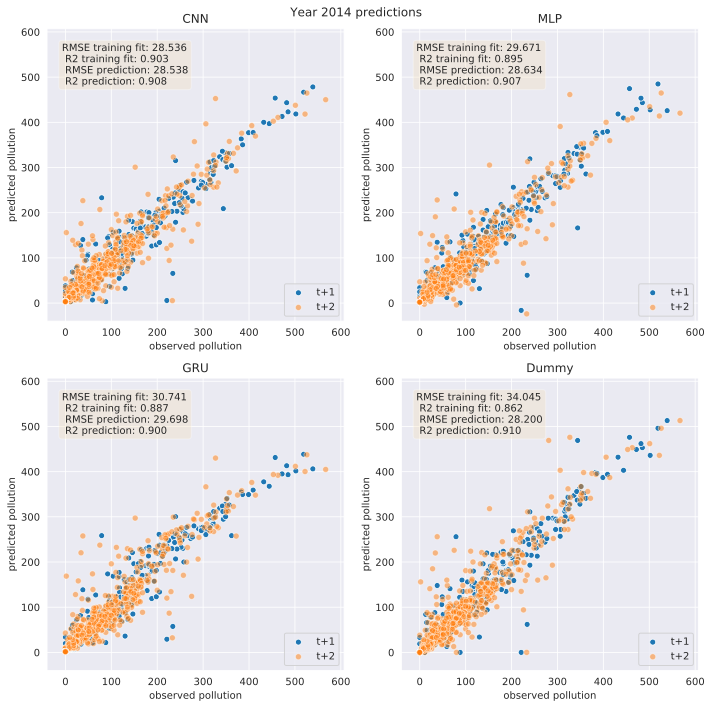

In [28]:
y_pred_train = np.zeros((y_train.shape[0],2,4))
y_pred_test = np.zeros((y_test.shape[0],2,4))
modelnames = ['CNN', 'MLP', 'GRU', 'Dummy']
models = [cnn,mlp,gru]
for i,nme in enumerate(modelnames):
    if i==3:
        y_pred_train[:,:,i] = dummy_prediction(X_train)
        y_pred_test[:,:,i] = dummy_prediction(X_test)
    else:
        y_pred_train[:,:,i] = models[i].predict(X_train)
        y_pred_test[:,:,i] = models[i].predict(X_test)
        
fig, axs = plt.subplots(2, 2, figsize=(10,10))
for i,ax in enumerate(axs.flat):
    textstr = 'RMSE training fit: %.03f\n R2 training fit: %.03f\n RMSE prediction: %.03f\n R2 prediction: %.03f' % (np.sqrt(mean_squared_error(y_train,y_pred_train[:,:,i])),
                                                                                                                    r2_score(y_train,y_pred_train[:,:,i]),
                                                                                                                    np.sqrt(mean_squared_error(y_test,y_pred_test[:,:,i])),
                                                                                                                    r2_score(y_test,y_pred_test[:,:,i]))
    minlim = y_test.min()
    maxlim = y_test.max()
    sns.scatterplot(x=y_test[:,0],y=y_pred_test[:,0,i],ax=ax, label='t+1')
    sns.scatterplot(x=y_test[:,1],y=y_pred_test[:,1,i],ax=ax,alpha=.5, label='t+2')
    ax.set_xlabel('observed pollution')
    ax.set_ylabel('predicted pollution')
    ax.set_xlim(minlim-40, maxlim+40)
    ax.set_ylim(minlim-40, maxlim+40)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
    ax.set_title(modelnames[i])
    ax.legend(loc=4)
fig.suptitle('Year 2014 predictions')
fig.tight_layout()
fig.subplots_adjust(top=0.95)